<a href="https://colab.research.google.com/github/KESAVAPRABHA/Forest_Fire_Prediction/blob/main/ForestFire_Prediction_DsProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import statsmodels.api as sm
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from scipy.stats import zscore
from statsmodels.stats.stattools import durbin_watson
from sklearn.model_selection import train_test_split,KFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LinearRegression,RidgeCV,LassoCV,ElasticNetCVm

In [ ]:
# path = 'forestfires.csv'
path = "/content/forestfires.csv"
df = pd.read_csv(path)

df.shape

(517, 13)

In [ ]:
df.dtypes

X          int64
Y          int64
month     object
day       object
FFMC     float64
DMC      float64
DC       float64
ISI      float64
temp     float64
RH         int64
wind     float64
rain     float64
area     float64
dtype: object

In [ ]:
df.describe().T

count        mean         std   min    25%     50%     75%      max
X     517.0    4.669246    2.313778   1.0    3.0    4.00    7.00     9.00
Y     517.0    4.299807    1.229900   2.0    4.0    4.00    5.00     9.00
FFMC  517.0   90.644681    5.520111  18.7   90.2   91.60   92.90    96.20
DMC   517.0  110.872340   64.046482   1.1   68.6  108.30  142.40   291.30
DC    517.0  547.940039  248.066192   7.9  437.7  664.20  713.90   860.60
ISI   517.0    9.021663    4.559477   0.0    6.5    8.40   10.80    56.10
temp  517.0   18.889168    5.806625   2.2   15.5   19.30   22.80    33.30
RH    517.0   44.288201   16.317469  15.0   33.0   42.00   53.00   100.00
wind  517.0    4.017602    1.791653   0.4    2.7    4.00    4.90     9.40
rain  517.0    0.021663    0.295959   0.0    0.0    0.00    0.00     6.40
area  517.0   12.847292   63.655818   0.0    0.0    0.52    6.57  1090.84

In [ ]:
df.isna().sum().sum()

0

In [ ]:
plt.rcParams["figure.figsize"] = 9,5

Skew: 12.846933533934868
Kurtosis: 194.1407210942299


<ipython-input-10-13da81b84d4d>:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(df[target],shade=True,color='g')


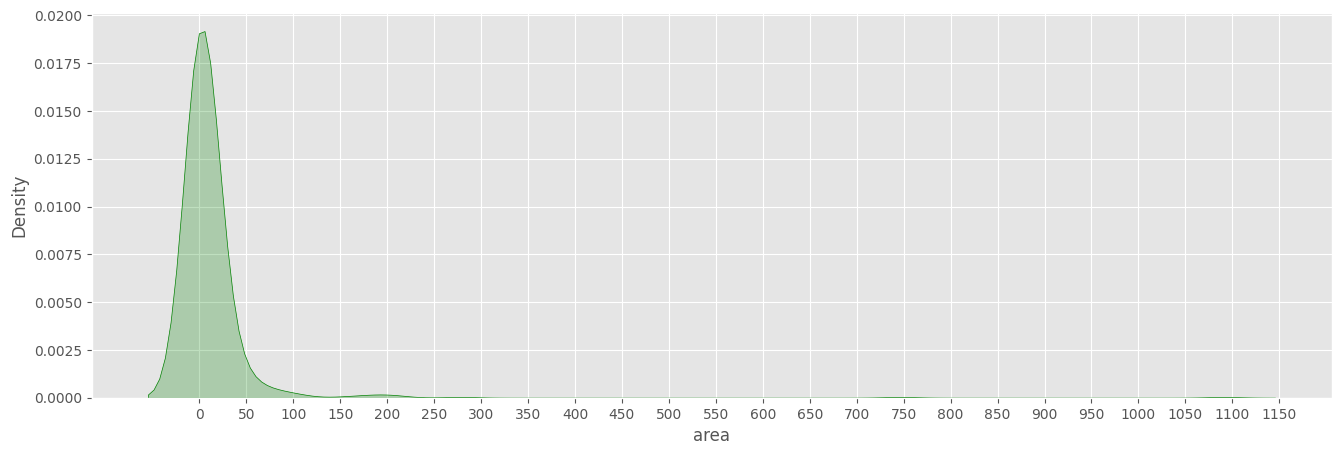

In [ ]:
plt.figure(figsize=(16,5))

# Define the target column before using it
target = 'area'  # Replace 'charges' with the actual name of the target column in your DataFrame

print("Skew: {}".format(df[target].skew()))
print("Kurtosis: {}".format(df[target].kurtosis()))
ax = sns.kdeplot(df[target],shade=True,color='g')
plt.xticks([i for i in range(0,1200,50)])
plt.show()

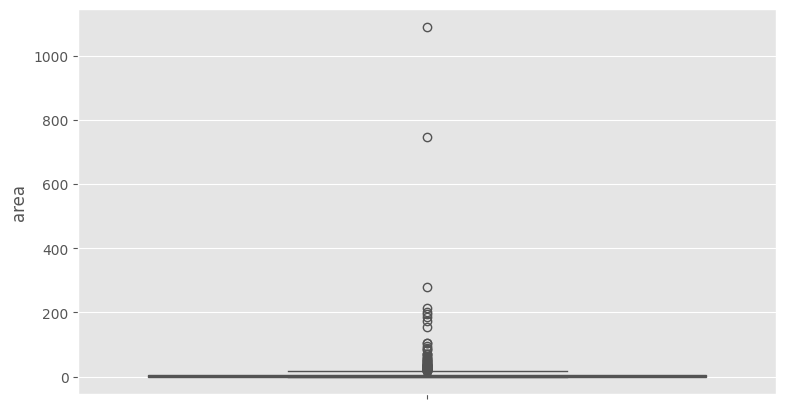

In [ ]:
ax = sns.boxplot(df[target])

In [ ]:
y_outliers = df[abs(zscore(df[target])) >= 3 ]
y_outliers


X  Y month  day  FFMC    DMC     DC   ISI  temp  RH  wind  rain     area
237  1  2   sep  tue  91.0  129.5  692.6   7.0  18.8  40   2.2   0.0   212.88
238  6  5   sep  sat  92.5  121.1  674.4   8.6  25.1  27   4.0   0.0  1090.84
415  8  6   aug  thu  94.8  222.4  698.6  13.9  27.5  27   4.9   0.0   746.28
479  7  4   jul  mon  89.2  103.9  431.6   6.4  22.6  57   4.9   0.0   278.53

In [ ]:
dfa = df.drop(columns=target)
cat_columns = dfa.select_dtypes(include='object').columns.tolist()
num_columns = dfa.select_dtypes(exclude='object').columns.tolist()

cat_columns,num_columns

(['month', 'day'],
 ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain'])

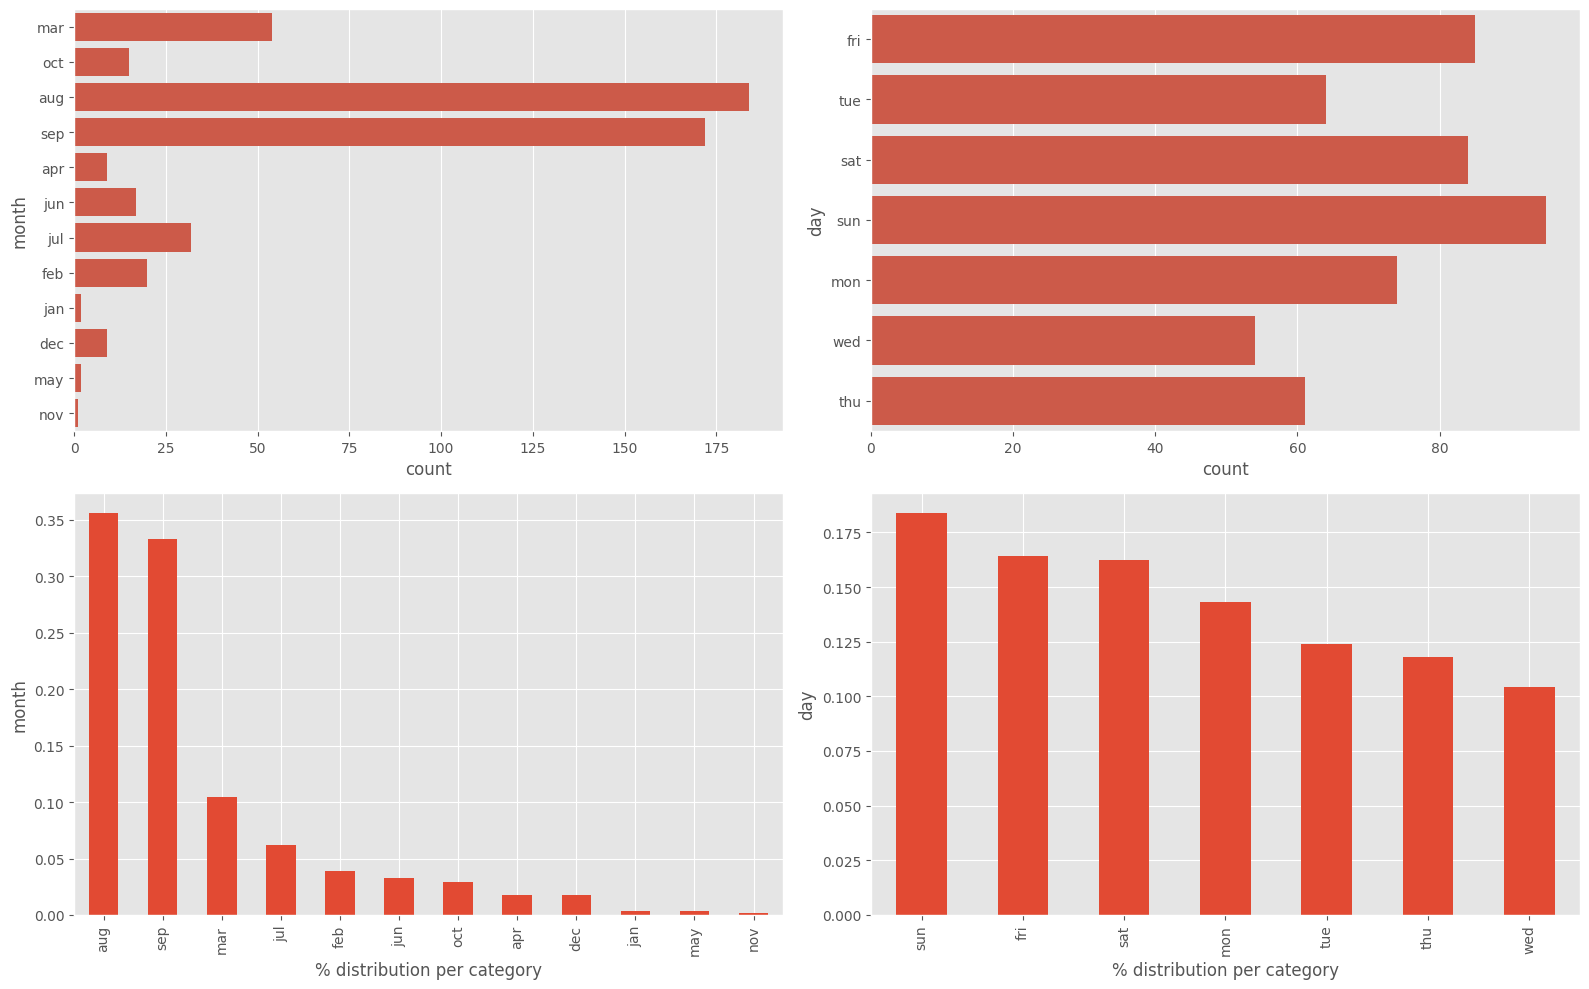

In [ ]:
# analyzing categorical columns
plt.figure(figsize=(16,10))
for i,col in enumerate(cat_columns,1):
    plt.subplot(2,2,i)
    sns.countplot(data=dfa,y=col)
    plt.subplot(2,2,i+2)
    df[col].value_counts(normalize=True).plot.bar()
    plt.ylabel(col)
    plt.xlabel('% distribution per category')
plt.tight_layout()
plt.show()

<ipython-input-18-580362cfca90>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[col],color='g',shade=True)
<ipython-input-18-580362cfca90>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[col],color='g',shade=True)
<ipython-input-18-580362cfca90>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[col],color='g',shade=True)
<ipython-input-18-580362cfca90>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[col],color='g',shade=True)
<ipython-input-18-580362cfca90>:4: FutureWarning: 

`shade` 

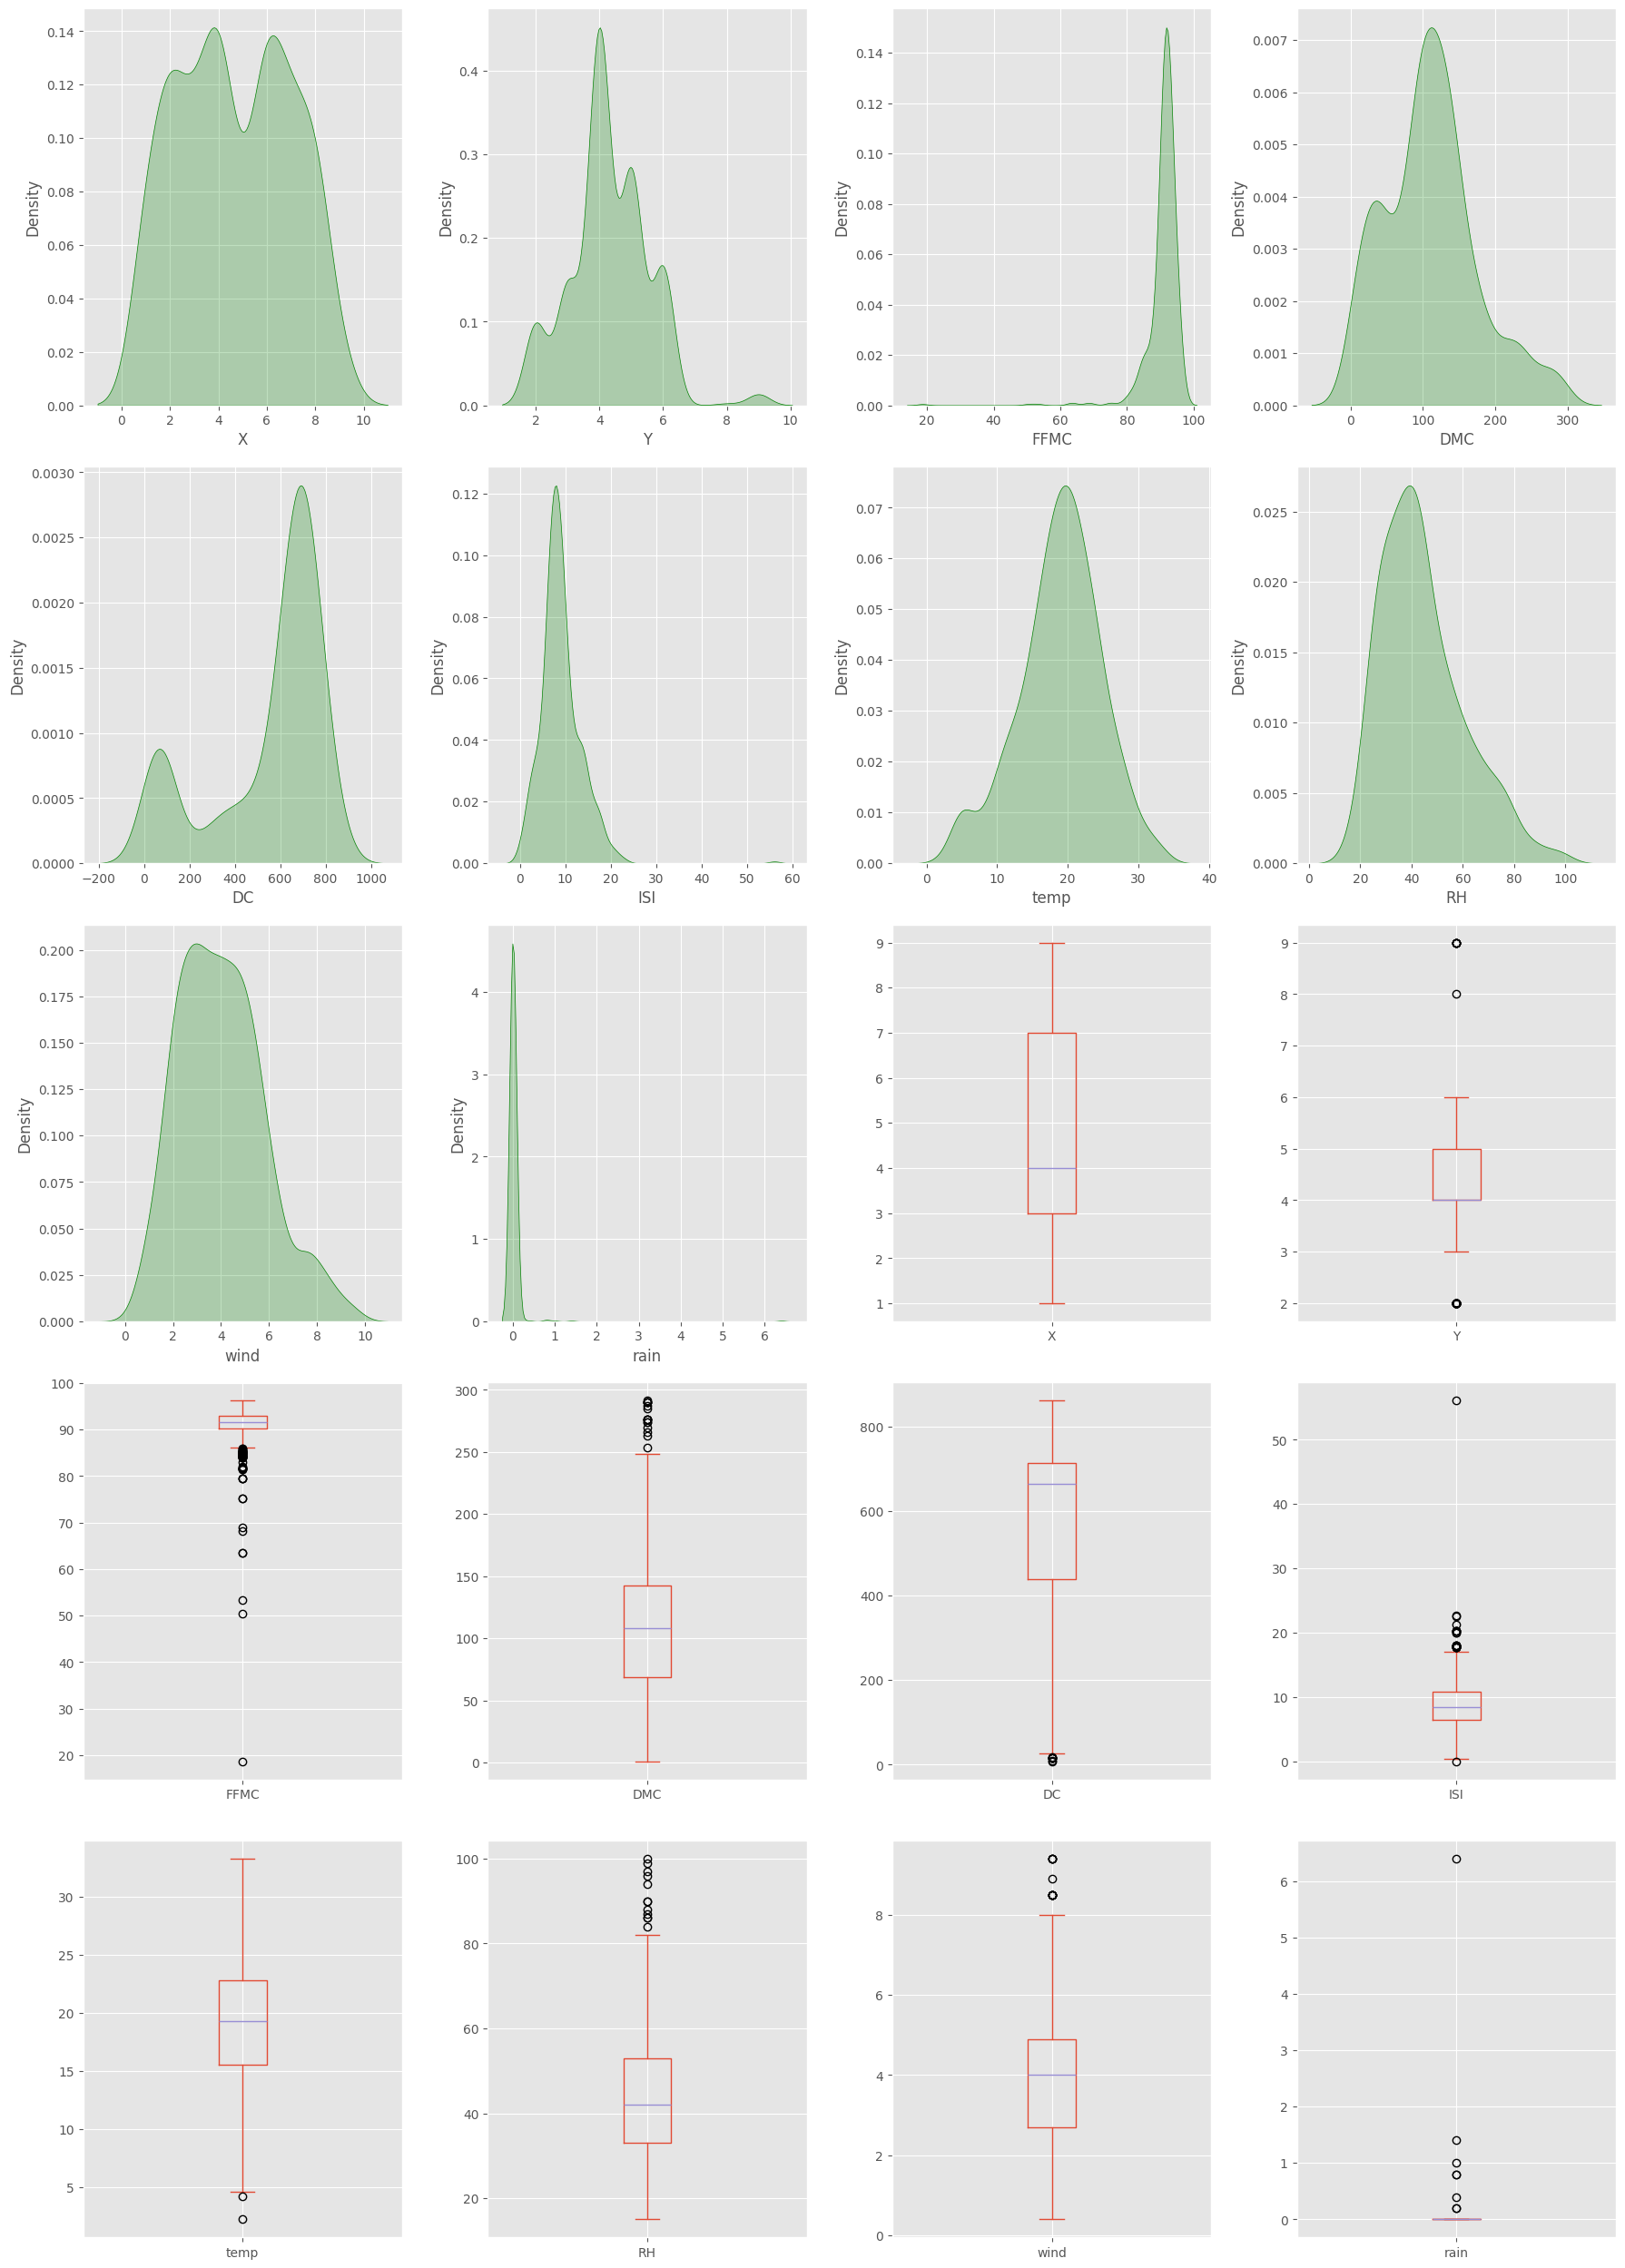

X         Y       FFMC       DMC        DC        ISI  \
skewness  0.036246  0.417296  -6.575606  0.547498 -1.100445   2.536325   
kurtosis -1.172331  1.420553  67.066041  0.204822 -0.245244  21.458037   

              temp        RH      wind        rain  
skewness -0.331172  0.862904  0.571001   19.816344  
kurtosis  0.136166  0.438183  0.054324  421.295964

In [ ]:
plt.figure(figsize=(18,40))
for i,col in enumerate(num_columns,1):
    plt.subplot(8,4,i)
    sns.kdeplot(df[col],color='g',shade=True)
    plt.subplot(8,4,i+10)
    df[col].plot.box()
plt.tight_layout()
plt.show()
num_data = df[num_columns]
pd.DataFrame(data=[num_data.skew(),num_data.kurtosis()],index=['skewness','kurtosis'])

In [ ]:
print(df['area'].describe(),'\n')
print(y_outliers)


count     517.000000
mean       12.847292
std        63.655818
min         0.000000
25%         0.000000
50%         0.520000
75%         6.570000
max      1090.840000
Name: area, dtype: float64 

     X  Y month  day  FFMC    DMC     DC   ISI  temp  RH  wind  rain     area
237  1  2   sep  tue  91.0  129.5  692.6   7.0  18.8  40   2.2   0.0   212.88
238  6  5   sep  sat  92.5  121.1  674.4   8.6  25.1  27   4.0   0.0  1090.84
415  8  6   aug  thu  94.8  222.4  698.6  13.9  27.5  27   4.9   0.0   746.28
479  7  4   jul  mon  89.2  103.9  431.6   6.4  22.6  57   4.9   0.0   278.53


In [ ]:
# a categorical variable based on forest fire area damage
# No damage, low, moderate, high, very high
def area_cat(area):
    if area == 0.0:
        return "No damage"
    elif area <= 1:
        return "low"
    elif area <= 25:
        return "moderate"
    elif area <= 100:
        return "high"
    else:
        return "very high"

df['damage_category'] = df['area'].apply(area_cat)
df.head()

X  Y month  day  FFMC   DMC     DC  ISI  temp  RH  wind  rain  area  \
0  7  5   mar  fri  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0   0.0   
1  7  4   oct  tue  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0   0.0   
2  7  4   oct  sat  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0   0.0   
3  8  6   mar  fri  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2   0.0   
4  8  6   mar  sun  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0   0.0   

  damage_category  
0       No damage  
1       No damage  
2       No damage  
3       No damage  
4       No damage

In [ ]:
cat_columns

['month', 'day']

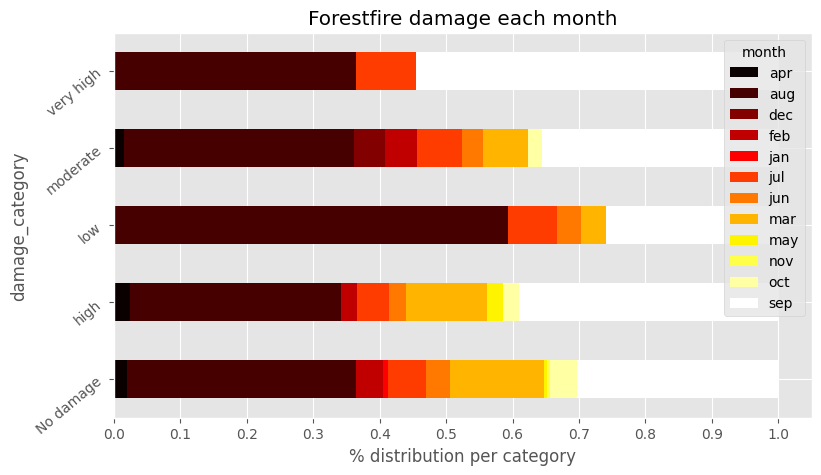

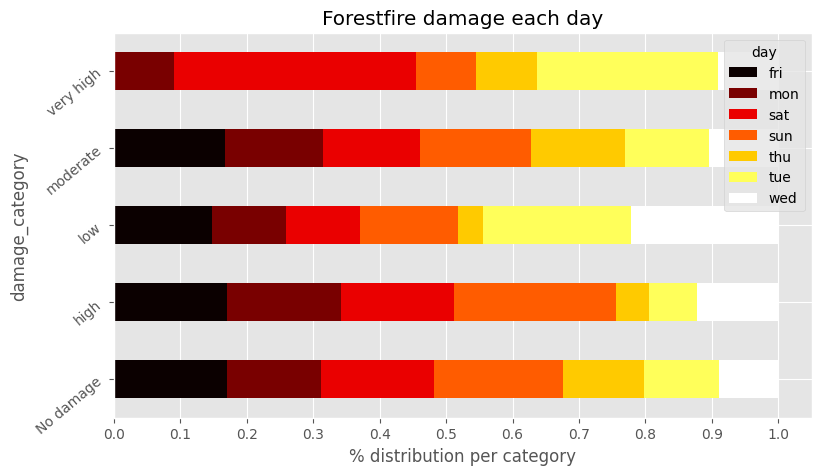

In [ ]:

for col in cat_columns:
    cross = pd.crosstab(index=df['damage_category'],columns=df[col],normalize='index')
    cross.plot.barh(stacked=True,rot=40,cmap='hot')
    plt.xlabel('% distribution per category')
    plt.xticks(np.arange(0,1.1,0.1))
    plt.title("Forestfire damage each {}".format(col))
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3399: UserWarning: 45.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3399: UserWarning: 68.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3399: UserWarning: 63.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3399: UserWarning: 64.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3399: UserWarning: 36.7% of the points cannot be plac

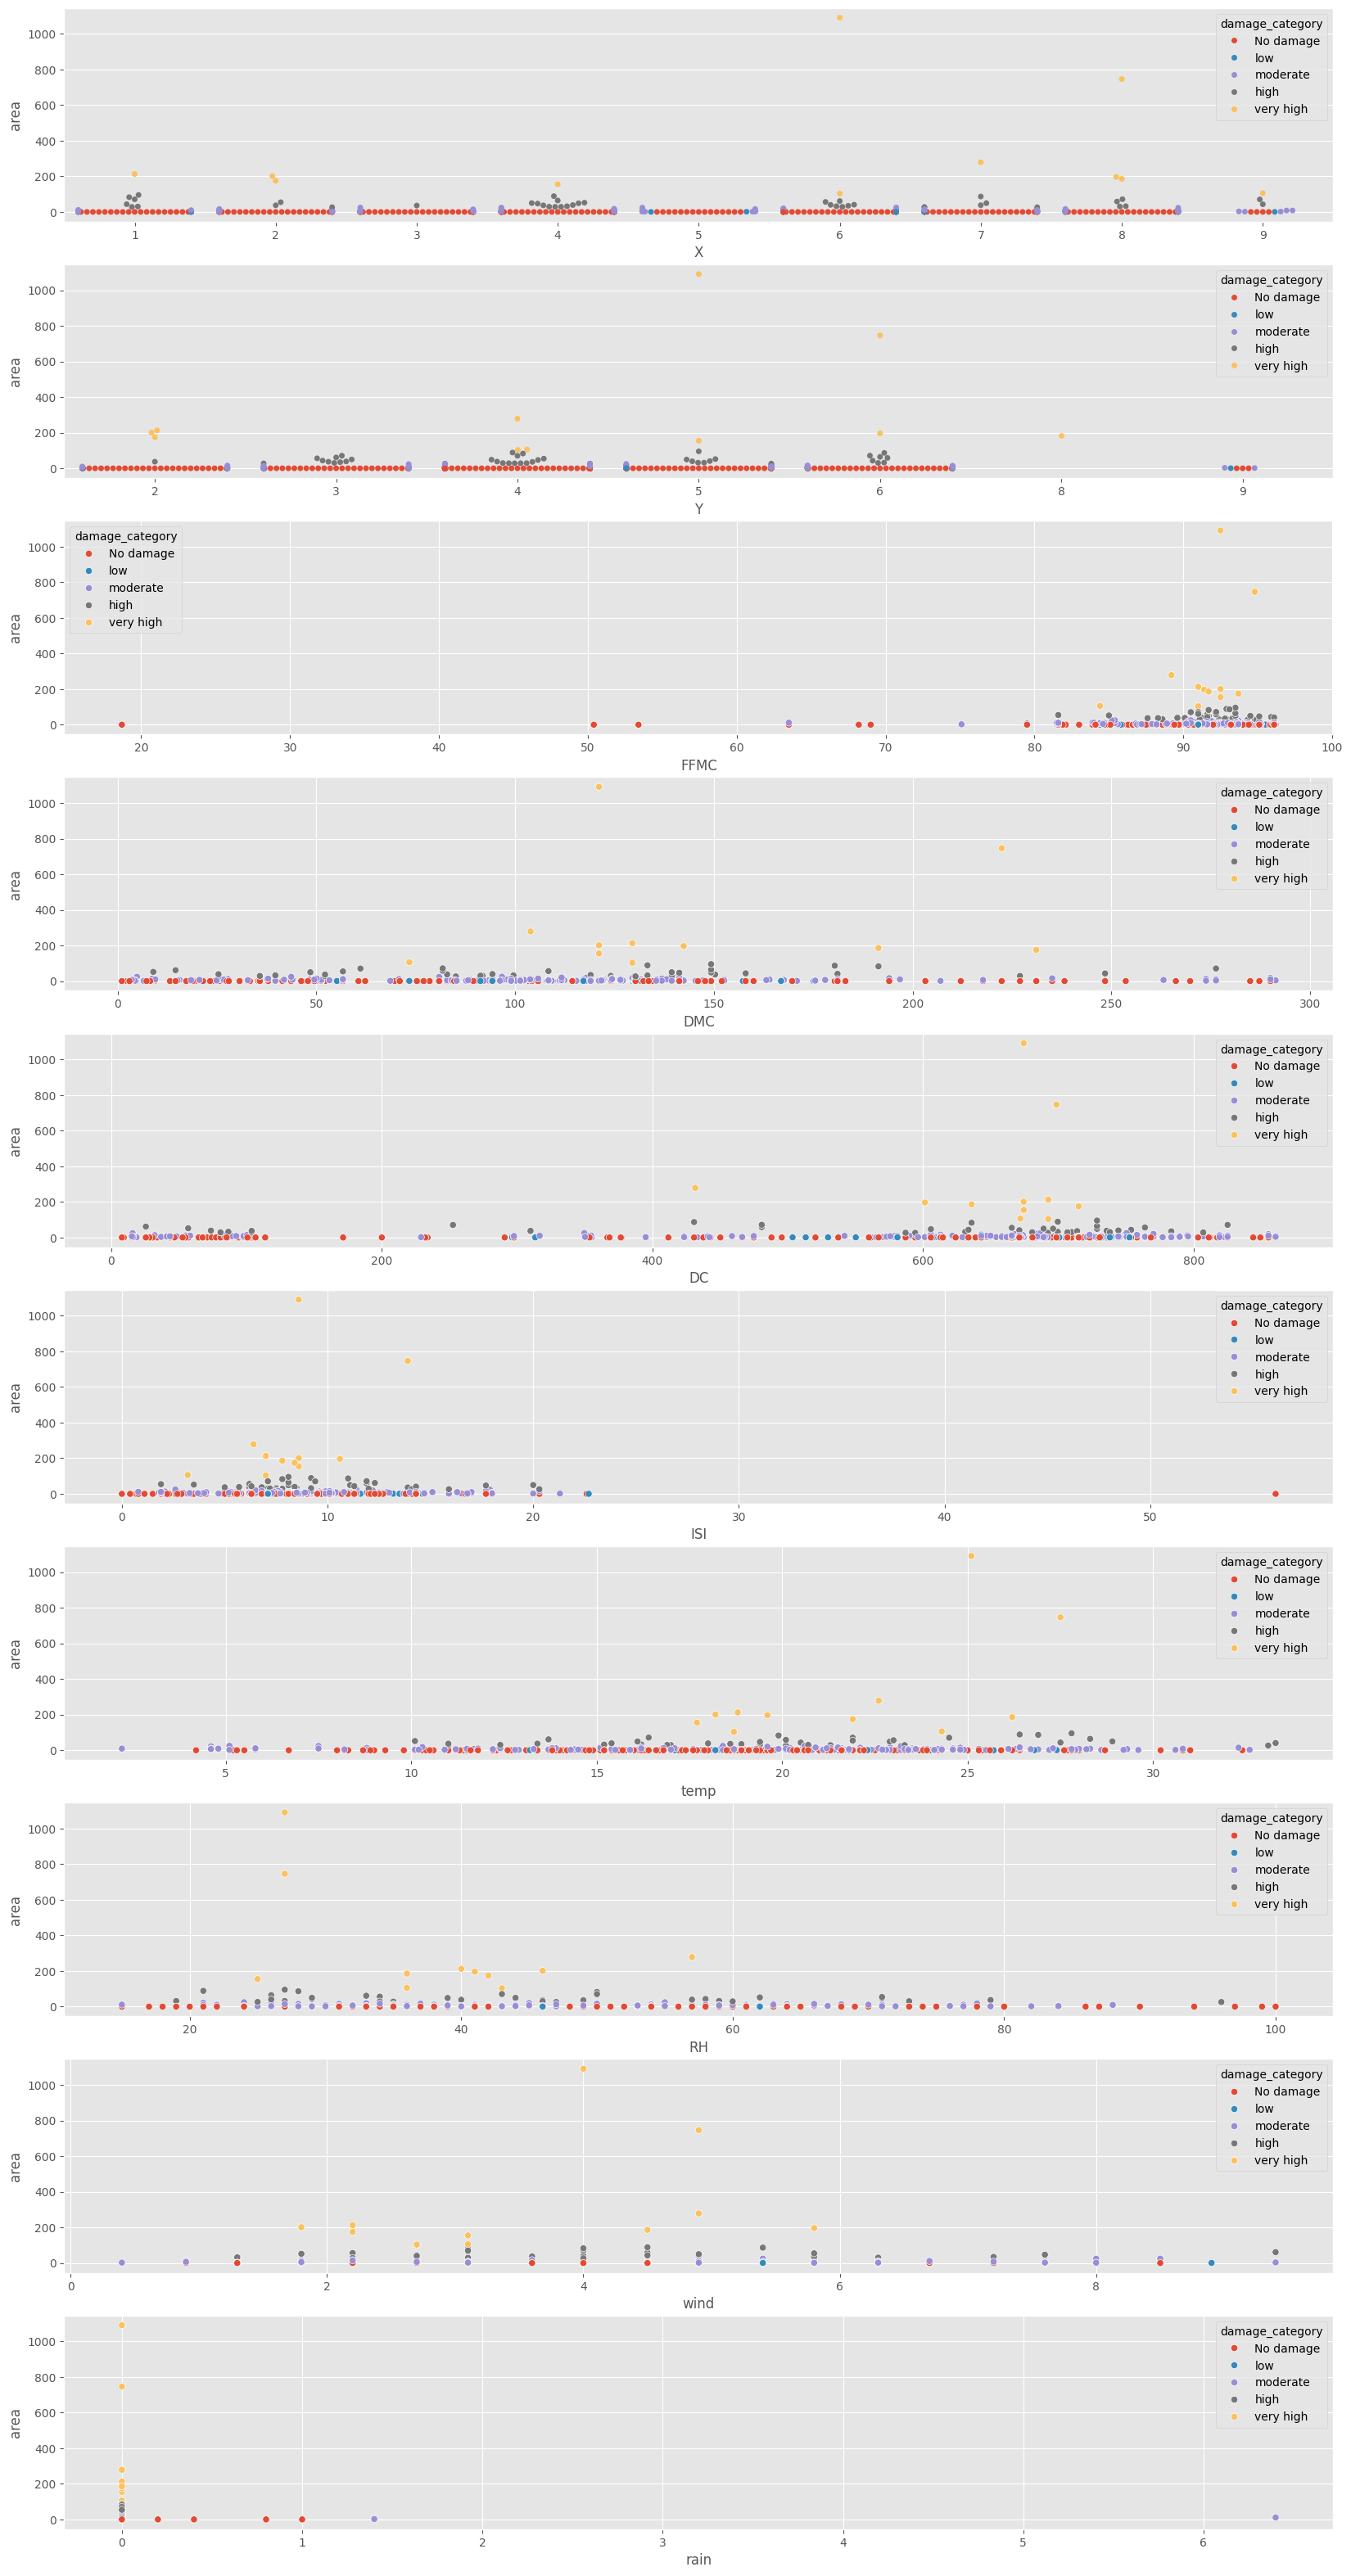

In [ ]:
plt.figure(figsize=(20,40))
for i,col in enumerate(num_columns,1):
    plt.subplot(10,1,i)
    if col in ['X','Y']:
        sns.swarmplot(data=df,x=col,y=target,hue='damage_category')
    else:
        sns.scatterplot(data=df,x=col,y=target,hue='damage_category')
plt.show()

In [ ]:
selected_features = df.drop(columns=['damage_category','day','month']).columns
selected_features

Index(['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain',
       'area'],
      dtype='object')

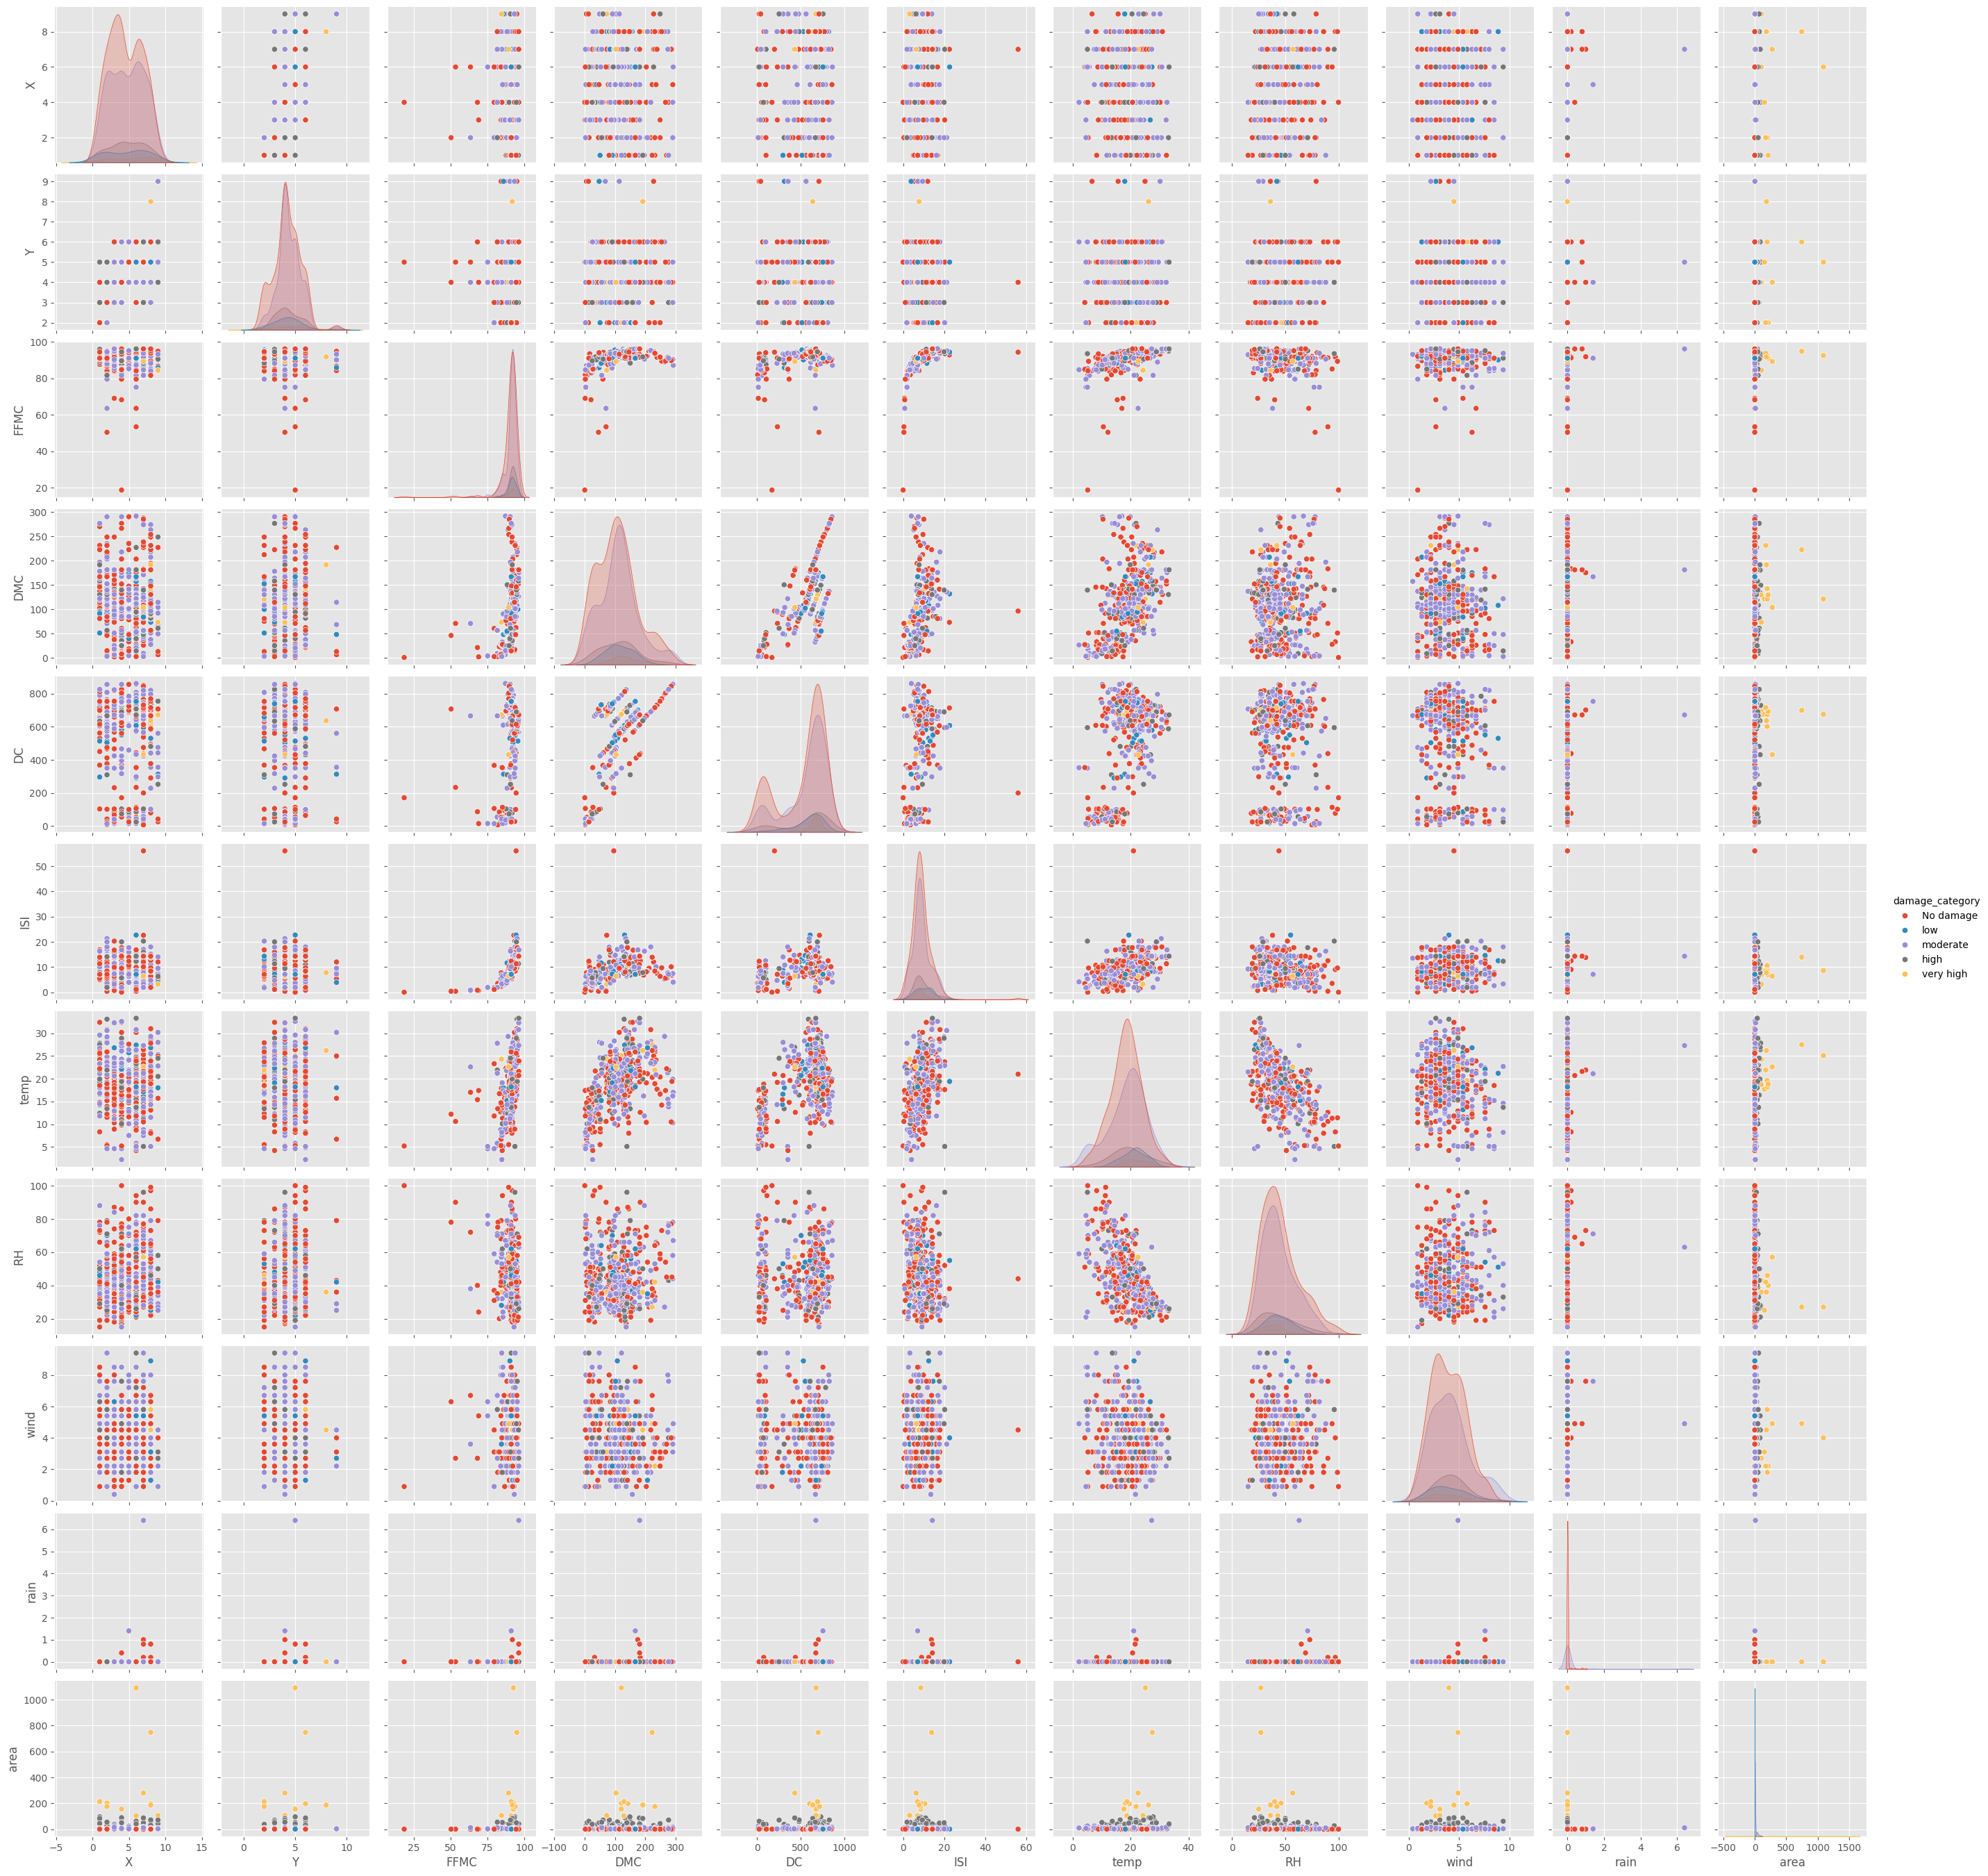

In [ ]:

sns.pairplot(df,hue='damage_category',vars=selected_features)
plt.show()

In [ ]:
out_columns = ['area','FFMC','ISI','rain']

In [ ]:
df = pd.get_dummies(df,columns=['day','month'],drop_first=True)

In [ ]:
print(df[out_columns].describe())
np.log1p(df[out_columns]).skew(), np.log1p(df[out_columns]).kurtosis()

              area        FFMC         ISI        rain
count   517.000000  517.000000  517.000000  517.000000
mean     12.847292   90.644681    9.021663    0.021663
std      63.655818    5.520111    4.559477    0.295959
min       0.000000   18.700000    0.000000    0.000000
25%       0.000000   90.200000    6.500000    0.000000
50%       0.520000   91.600000    8.400000    0.000000
75%       6.570000   92.900000   10.800000    0.000000
max    1090.840000   96.200000   56.100000    6.400000


(area     1.217838
 FFMC   -11.675394
 ISI     -0.937218
 rain    14.173028
 dtype: float64,
 area      0.945668
 FFMC    185.482383
 ISI       2.584588
 rain    234.240025
 dtype: float64)

In [ ]:
mask = df.loc[:,['FFMC']].apply(zscore).abs() < 3

# Since most of the values in rain are 0.0, we can convert it as a categorical column
df['rain'] = df['rain'].apply(lambda x: int(x > 0.0))

df = df[mask.values]
df.shape


(510, 29)

In [ ]:
out_columns.remove('rain')
df[out_columns] = np.log1p(df[out_columns])

In [ ]:
df[out_columns].skew()

area    1.208492
FFMC   -1.803993
ISI    -0.434372
dtype: float64

In [ ]:
df_ml = df.drop(columns=['damage_category']).copy()

In [ ]:
X = df.drop(columns=['area','damage_category'])
y = df['area']

In [ ]:
print(X.dtypes)  # Display the data types of each column in X
print(y.dtype)   # Display the data type of y


X              int64
Y              int64
FFMC         float64
DMC          float64
DC           float64
ISI          float64
temp         float64
RH             int64
wind         float64
rain           int64
day_mon         bool
day_sat         bool
day_sun         bool
day_thu         bool
day_tue         bool
day_wed         bool
month_aug       bool
month_dec       bool
month_feb       bool
month_jan       bool
month_jul       bool
month_jun       bool
month_mar       bool
month_may       bool
month_nov       bool
month_oct       bool
month_sep       bool
dtype: object
float64


In [ ]:
# Convert all boolean columns in X to integers
X = X.astype({col: 'int64' for col in X.select_dtypes(include=['bool']).columns})

# Add a constant to X for the OLS model
X_constant = sm.add_constant(X)

# Build and fit the OLS model
lin_reg = sm.OLS(y, X_constant).fit()
print(lin_reg.summary())


                            OLS Regression Results                            
Dep. Variable:                   area   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     1.489
Date:                Tue, 12 Nov 2024   Prob (F-statistic):             0.0558
Time:                        06:20:20   Log-Likelihood:                -874.85
No. Observations:                 510   AIC:                             1806.
Df Residuals:                     482   BIC:                             1924.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3192     18.275      0.017      0.9

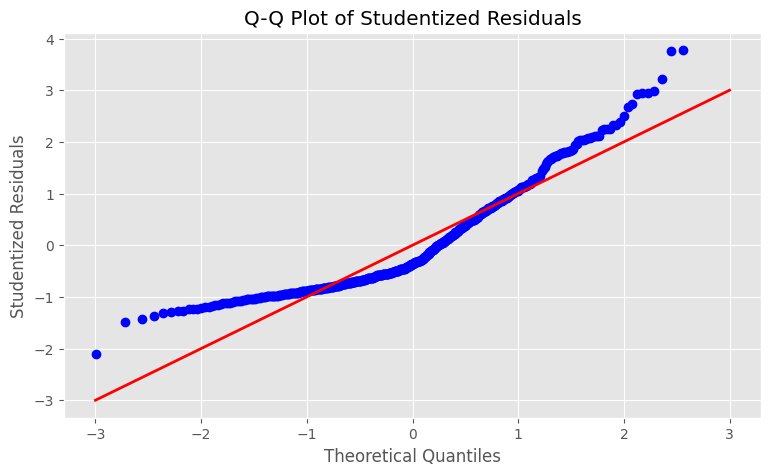

In [ ]:
import scipy.stats as stats
import pylab
import matplotlib.pyplot as plt

# Get the studentized residuals
st_resid = lin_reg.get_influence().resid_studentized_internal

# Q-Q plot
stats.probplot(st_resid, dist="norm", plot=pylab)

# Manually add a 45-degree reference line
plt.plot([-3, 3], [-3, 3], color='red', linestyle='-', lw=2)  # Adjust as needed

# Show plot
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Studentized Residuals")
plt.title("Q-Q Plot of Studentized Residuals")
plt.show()


In [ ]:
sm.stats.diagnostic.linear_rainbow(lin_reg)

(1.2832659161650866, 0.027048891500426574)

In [ ]:
lin_reg.resid.mean()

-2.7864421010200007e-17

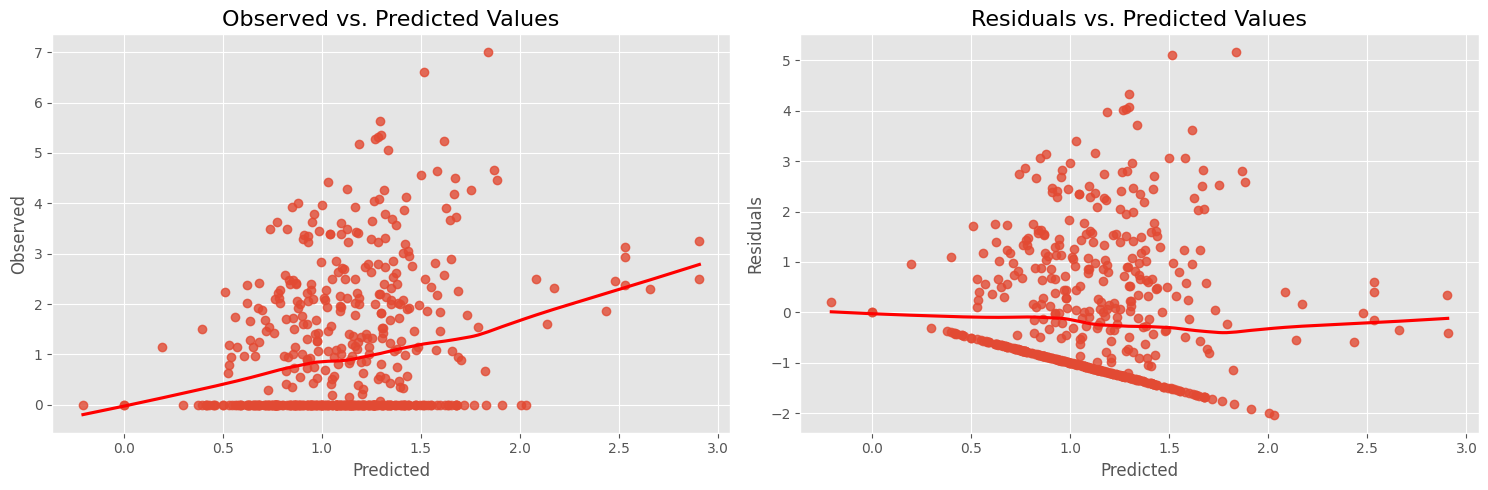

In [ ]:
def linearity_test(model, y):
    '''
    Function for visually inspecting the assumption of linearity in a linear regression model.
    It plots observed vs. predicted values and residuals vs. predicted values.

    Args:
    * model - fitted OLS model from statsmodels
    * y - observed values
    '''
    fitted_vals = model.predict()
    resids = model.resid

    fig, ax = plt.subplots(1,2,figsize=(15,5))

    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Observed vs. Predicted Values', fontsize=16)
    ax[0].set(xlabel='Predicted', ylabel='Observed')

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Residuals vs. Predicted Values', fontsize=16)
    ax[1].set(xlabel='Predicted', ylabel='Residuals')

linearity_test(lin_reg, y)
plt.tight_layout()

<ipython-input-48-bdd509d758de>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(lin_reg.resid,fit=stats.norm)


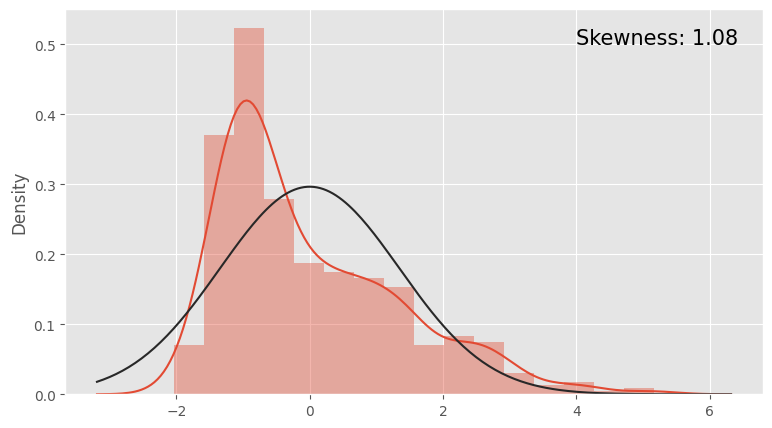

In [ ]:
sns.distplot(lin_reg.resid,fit=stats.norm)
plt.text(4,0.5,f"Skewness: {round(lin_reg.resid.skew(),2)}",fontsize=15)
plt.show()

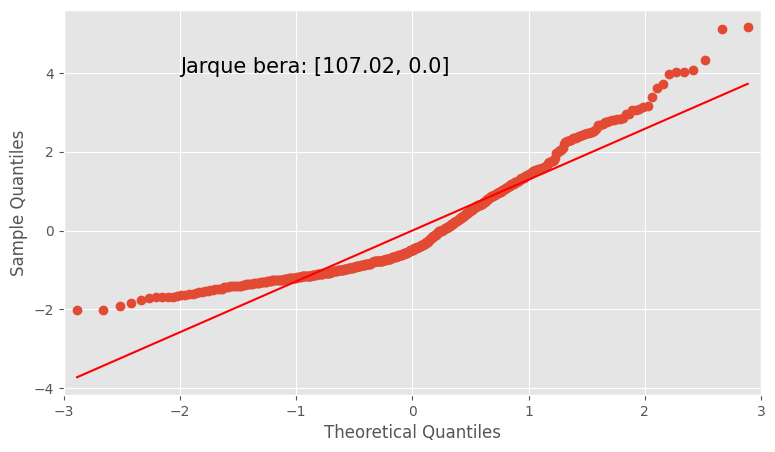

In [ ]:
sm.qqplot(lin_reg.resid,line ='r')
jb = [round(n,2) for n in stats.jarque_bera(lin_reg.resid)]
plt.text(-2,4,f"Jarque bera: {jb}",fontsize=15)
plt.show()

In [ ]:
sms.het_goldfeldquandt(lin_reg.resid, lin_reg.model.exog)

(0.9005330268628146, 0.7860123901512466, 'increasing')

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:847: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:847: RuntimeWarning: divide by zero encountered in divide
  return self.resid / sigma / np.sqrt(1 - hii)


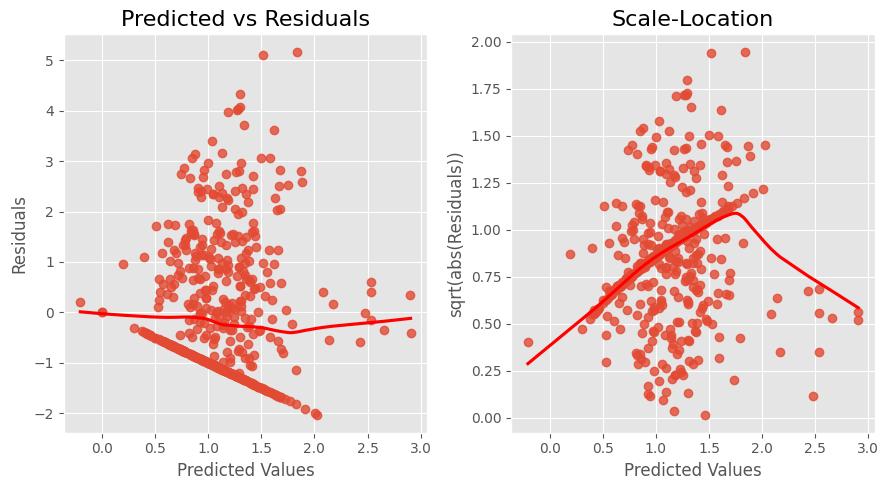

In [ ]:
model = lin_reg
fitted_vals = model.predict()
resids = model.resid
resids_standardized = model.get_influence().resid_studentized_internal

fig, ax = plt.subplots(1,2)

sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[0], line_kws={'color': 'red'})
ax[0].set_title('Predicted vs Residuals', fontsize=16)
ax[0].set(xlabel='Predicted Values', ylabel='Residuals')

sns.regplot(x=fitted_vals, y=np.sqrt(np.abs(resids_standardized)), lowess=True, ax=ax[1], line_kws={'color': 'red'})
ax[1].set_title('Scale-Location', fontsize=16)
ax[1].set(xlabel='Predicted Values', ylabel='sqrt(abs(Residuals))')

name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(model.resid, model.model.exog)
lzip(name, test)
plt.tight_layout()


In [ ]:
from statsmodels.stats.stattools import durbin_watson
durbin_watson(lin_reg.resid)

0.9793850110864487

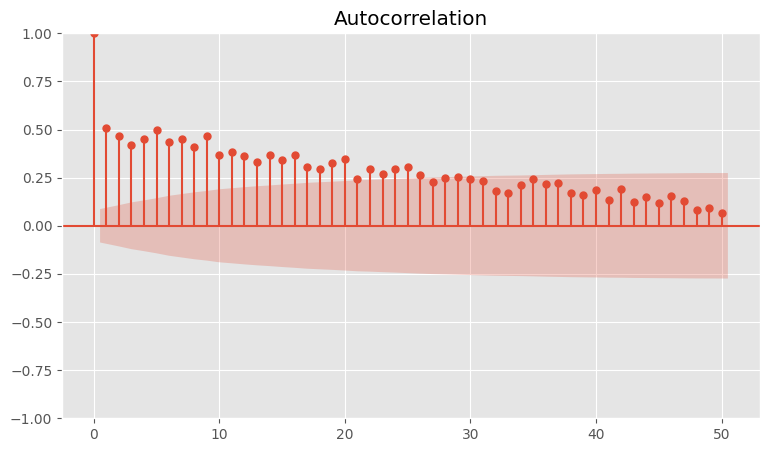

In [ ]:
import statsmodels.tsa.api as smt
# Confidence intervals are drawn as a cone.
# By default, this is set to a 95% confidence interval,
# suggesting that correlation values outside of this code are very likely a correlation
# and not a statistical fluke
acf = smt.graphics.plot_acf(lin_reg.resid, lags=50 , alpha=0.05)
acf.show()

Dropping column 'damage_category' due to non-numeric values.


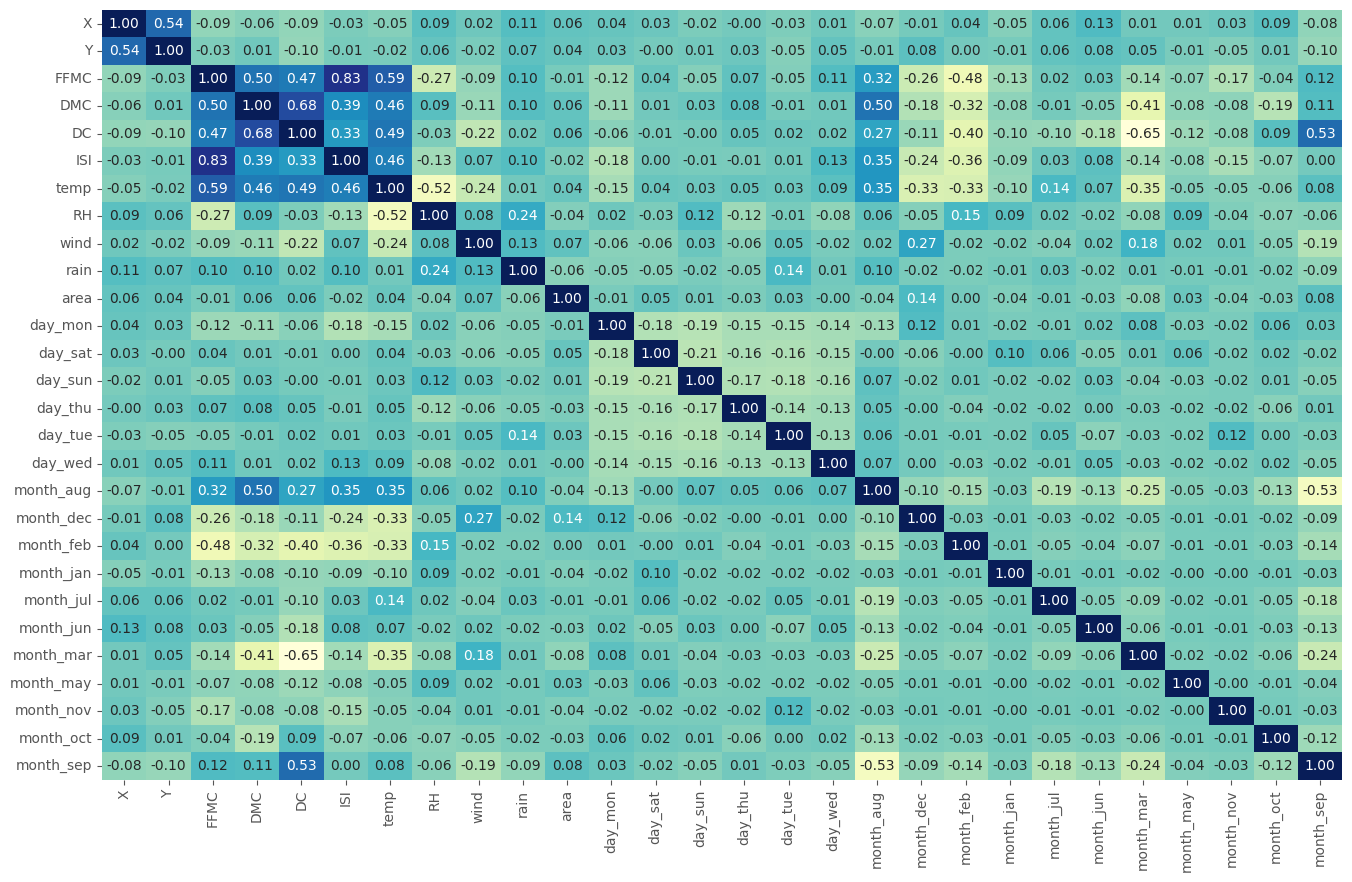

In [ ]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame
# Convert 'object' columns to numeric where possible, otherwise drop
# Create a list of columns to potentially drop
drop_cols = []
for col in df.select_dtypes(include=['object']).columns:
    # Try to convert the column to numeric
    try:
        df[col] = pd.to_numeric(df[col])
    except ValueError:
        # If conversion fails, add the column to the drop list
        drop_cols.append(col)
        print(f"Dropping column '{col}' due to non-numeric values.")

# If there are columns to drop, drop them
if drop_cols:
    df = df.drop(columns=drop_cols)

# Now calculate the correlation matrix and plot the heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(df.corr(), annot=True, cmap='YlGnBu', fmt=".2f", cbar=False)
plt.show()

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(X_constant.values, i) for i in range(X_constant.shape[1])]
pd.DataFrame({'vif': vif[1:]}, index=X.columns).sort_values(by="vif",ascending=False)

vif
month_sep  53.307716
month_aug  43.939403
DC         26.792896
month_jul   8.378570
month_oct   7.681340
month_mar   6.694845
FFMC        5.629386
temp        4.535721
ISI         4.107793
DMC         3.978913
month_jun   3.731938
month_feb   3.077978
month_dec   2.984761
RH          2.870672
day_sun     1.829250
day_sat     1.750570
day_mon     1.733149
day_thu     1.654243
day_tue     1.653962
day_wed     1.547815
X           1.539358
Y           1.521475
wind        1.323007
month_may   1.273889
rain        1.231386
month_nov   1.157750
month_jan   1.146912

In [ ]:
lr = LinearRegression()
lr.fit(X, y)

print(f'Intercept: {lr.intercept_}')
print(f'R^2 score: {lr.score(X, y)}')
pd.DataFrame({"Coefficients": lr.coef_}, index=X.columns)

Intercept: 0.3192068355152282
R^2 score: 0.0769861533829217


Coefficients
X              0.053161
Y             -0.011457
FFMC          -0.106058
DMC            0.004149
DC            -0.001854
ISI           -0.103922
temp           0.044297
RH             0.004063
wind           0.067775
rain          -0.927225
day_mon        0.107572
day_sat        0.331167
day_sun        0.179442
day_thu        0.071364
day_tue        0.348268
day_wed        0.196002
month_aug      0.244968
month_dec      2.222281
month_feb      0.221676
month_jan     -0.860523
month_jul      0.031948
month_jun     -0.331633
month_mar     -0.261304
month_may      0.625607
month_nov     -1.177853
month_oct      0.771841
month_sep      0.897800

In [ ]:
X = df.drop(columns=['area'])
y = df['area']

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

def check_stats(X, y):
    # Convert all columns of X to numeric, coerce errors to NaN
    X = X.apply(pd.to_numeric, errors='coerce')

    # Convert boolean columns to integers (0 and 1)
    X = X.astype({col: 'int64' for col, dtype in X.dtypes.items() if dtype == 'bool'})

    # Drop any rows with NaN or infinite values in X
    X = X.replace([np.inf, -np.inf], np.nan).dropna()

    # Align y with X after dropping rows
    y = y.loc[X.index]

    # Check data types to confirm everything is now int64 or float64
    print("Data types after conversion:\n", X.dtypes)

    # Calculate VIF for each feature in X
    vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print(pd.DataFrame({'vif': vif}, index=X.columns).sort_values(by="vif", ascending=False)[:10])

    # Add constant to X for intercept in the OLS regression
    X_constant = sm.add_constant(X)

    # Fit the OLS model
    lin_reg = sm.OLS(y, X_constant).fit()
    print(lin_reg.summary())

# Example usage:
# Assuming 'df' is your DataFrame and 'area' is your target variable
X = df.drop(columns=['area'])
y = df['area']

# Call the function to check stats
check_stats(X, y)


Data types after conversion:
 X              int64
Y              int64
FFMC         float64
DMC          float64
DC           float64
ISI          float64
temp         float64
RH             int64
wind         float64
rain           int64
day_mon        int64
day_sat        int64
day_sun        int64
day_thu        int64
day_tue        int64
day_wed        int64
month_aug      int64
month_dec      int64
month_feb      int64
month_jan      int64
month_jul      int64
month_jun      int64
month_mar      int64
month_may      int64
month_nov      int64
month_oct      int64
month_sep      int64
dtype: object
                  vif
FFMC       202.334784
DC         159.585267
month_sep   77.976513
month_aug   67.081874
temp        53.012135
ISI         52.449380
RH          23.764931
Y           19.961996
DMC         15.417494
month_jul    8.764939
                            OLS Regression Results                            
Dep. Variable:                   area   R-squared:                  

In [ ]:
X.drop(columns=['FFMC'],inplace=True)

In [ ]:
X.drop(columns=['Y'],inplace=True)

In [ ]:
X.drop(columns=['month_jul'],inplace=True)

In [ ]:
X.drop(columns=['day_thu'],inplace=True)

In [ ]:
X.drop(columns=['day_mon'],inplace=True)

In [ ]:
X.drop(columns=['month_aug'],inplace=True)

In [ ]:
X_m, y_m = df_ml.drop(columns=[target]), df_ml[target]

Out of 27 features, best number of features 1


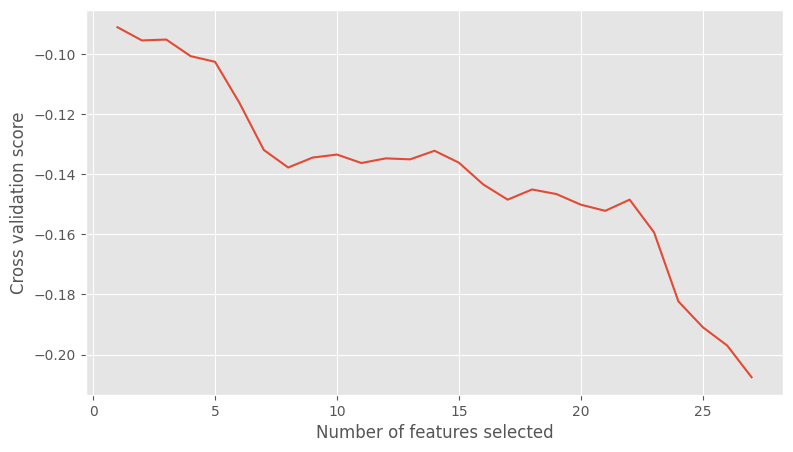

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt

# Assuming X_m and y_m are your features and target variable
model = LinearRegression()
selector = RFECV(model, cv=5)
selector = selector.fit(X_m, y_m)

print(f"Out of {len(X_m.columns)} features, best number of features {selector.n_features_}")

# Plotting the number of features selected against cross-validation score
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(X_m.columns) + 1), selector.cv_results_['mean_test_score'])
plt.show()


Out of 27 features, best number of features 19
Selected features: ['X' 'wind' 'rain' 'day_mon' 'day_sat' 'day_sun' 'day_thu' 'day_tue'
 'day_wed' 'month_aug' 'month_dec' 'month_feb' 'month_jan' 'month_jul'
 'month_jun' 'month_mar' 'month_may' 'month_nov' 'month_oct']


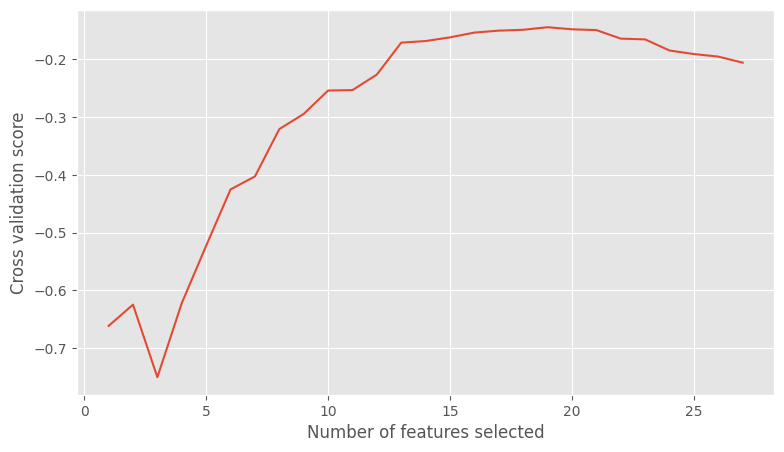

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt

# Model with no intercept
model = LinearRegression(fit_intercept=False)
selector = RFECV(model, cv=5)
selector = selector.fit(X_m, y_m)

# Print best number of features and selected feature names
print(f"Out of {len(X_m.columns)} features, best number of features {selector.n_features_}")
print("Selected features:", X_m.columns[selector.support_].values)

# Plotting the cross-validation score for each number of features selected
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(selector.cv_results_['mean_test_score']) + 1), selector.cv_results_['mean_test_score'])
plt.show()


In [ ]:
mask = selector.support_
print(f"Best features according to RFE {X_m.columns[mask].values}")

X_m1 = X_m.iloc[:,mask]
# We could have used train test split or cross validation strategies
# for scoring the model but in order to compare with the stats model
# we will use the whole data
model1 = LinearRegression().fit(X_m1,y_m)
print(f"R2 Score: {model1.score(X_m1,y_m)}")

Best features according to RFE ['X' 'wind' 'rain' 'day_mon' 'day_sat' 'day_sun' 'day_thu' 'day_tue'
 'day_wed' 'month_aug' 'month_dec' 'month_feb' 'month_jan' 'month_jul'
 'month_jun' 'month_mar' 'month_may' 'month_nov' 'month_oct']
R2 Score: 0.05542824436801641


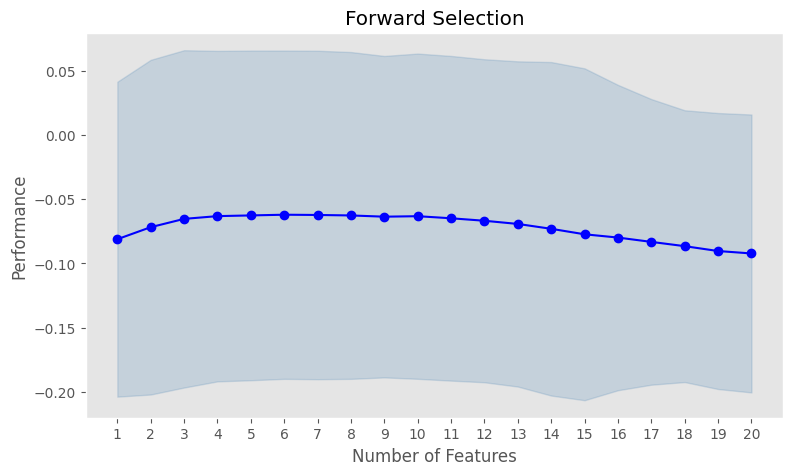

In [ ]:
model = LinearRegression(fit_intercept=False)
sfs1 = sfs(model,k_features=20,forward=True,scoring='r2',cv=5)
sfs1.fit(X_m,y_m)
fig = plot_sfs(sfs1.get_metric_dict())
plt.title('Forward Selection')
plt.grid()
plt.show()

In [ ]:
print(sfs1.k_features, sfs1.k_feature_names_,sep="\n")

(20, 20)
('X', 'FFMC', 'ISI', 'RH', 'wind', 'rain', 'day_mon', 'day_sat', 'day_sun', 'day_thu', 'day_tue', 'day_wed', 'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_mar', 'month_nov', 'month_oct')


In [ ]:
index = list(sfs1.k_feature_idx_)
X_m1 = X_m.iloc[:,index]
model1 = LinearRegression().fit(X_m1,y_m)
print(f"R2 Score: {model1.score(X_m1,y_m)}")

R2 Score: 0.054721988510710196


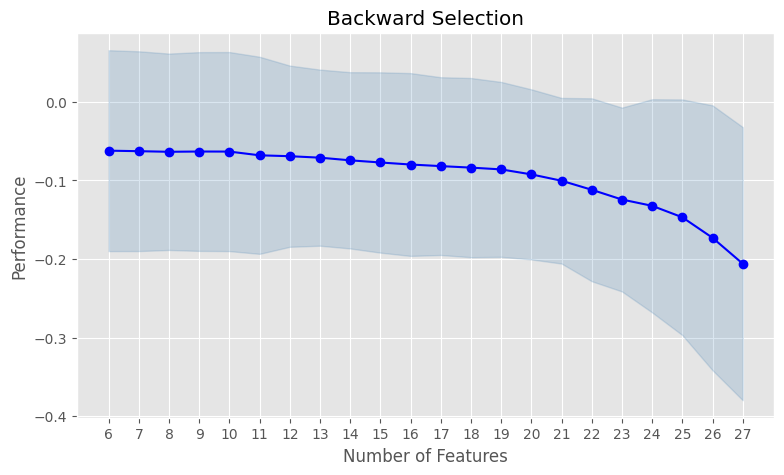

In [ ]:
model = LinearRegression(fit_intercept=False)
sfs1 = sfs(model,k_features=6,forward=False,scoring='r2',cv=5)
sfs1.fit(X_m,y_m)
fig = plot_sfs(sfs1.get_metric_dict())
plt.title('Backward Selection')
plt.grid(True)
plt.show()

In [ ]:
index = list(sfs1.k_feature_idx_)
print(f"Best features according to RFE: {X_m.columns[index]}")

X_m1 = X_m.iloc[:,index]
model1 = LinearRegression().fit(X_m1,y_m)
print(f"R2 Score: {model1.score(X_m1,y_m)}")

Best features according to RFE: Index(['X', 'FFMC', 'rain', 'month_jan', 'month_mar', 'month_nov'], dtype='object')
R2 Score: 0.01821264603161088


In [ ]:
# higher the alpha value, more restriction on the coefficients;
# lower the alpha > more generalization, coefficients are barely
rr = RidgeCV(cv=5,fit_intercept=False)
rr.fit(X_m, y_m)
rr.score(X_m,y_m)

0.06055519668815179

In [ ]:
rr.alpha_

10.0

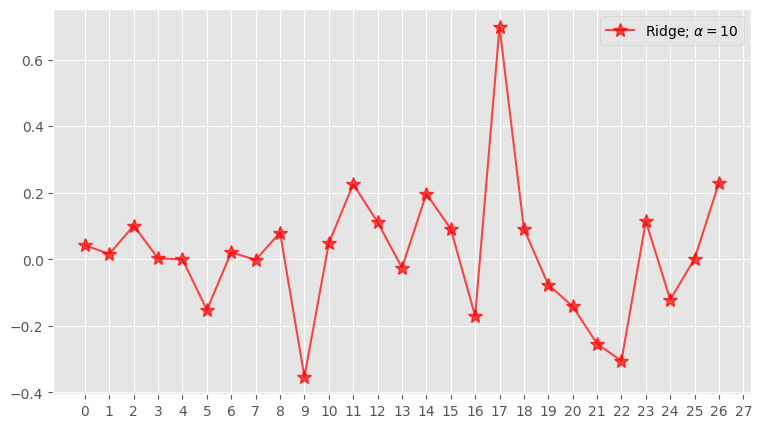

In [ ]:
plt.plot(rr.coef_,alpha=0.7,marker='*',markersize=10,color='red',label=r'Ridge; $\alpha =10$')
plt.grid(True)
plt.xticks(range(0,28,1))
plt.legend()
plt.show()

In [ ]:
import streamlit as st
import numpy as np
import joblib

# Load the trained model
model = joblib.load('forest_fire_model.pkl')  # Save the model first as forest_fire_model.pkl

# Input form for user data
st.title("Forest Fire Impact Prediction")
st.write("Enter values for the following parameters to predict the burned area:")

# Get user input for relevant features
month = st.selectbox("Month", range(1, 13))
day = st.selectbox("Day of the week", range(1, 8))
temp = st.slider("Temperature (°C)", 0.0, 50.0, step=0.1)
RH = st.slider("Relative Humidity (%)", 0, 100, step=1)
wind = st.slider("Wind Speed (km/h)", 0.0, 10.0, step=0.1)
rain = st.slider("Rainfall (mm)", 0.0, 10.0, step=0.1)
FFMC = st.slider("FFMC index", 0.0, 100.0, step=0.1)
DMC = st.slider("DMC index", 0.0, 300.0, step=0.1)
DC = st.slider("DC index", 0.0, 800.0, step=0.1)
ISI = st.slider("ISI index", 0.0, 50.0, step=0.1)

# Predict button
if st.button("Predict Burned Area"):
    # Prepare data for prediction
    input_data = np.array([[month, day, FFMC, DMC, DC, ISI, temp, RH, wind, rain]])
    prediction = model.predict(input_data)
    st.write(f"Predicted Burned Area: {prediction[0]:.2f} hectares")


ModuleNotFoundError: No module named 'streamlit'